# Crack detection with PyTorch

Adrian P. Bustamante, Ph.D.

adrianpebus@gmail.com

## 1. Objective

Crack detection has vital importance for structural health monitoring and inspection. We would like to train a convolutional neural network to detect Cracks, we will denote the images that contain cracks as positive and images with no cracks as negative.

This short project is part of the IBM AI Engineering Professional Certificate, https://www.coursera.org/professional-certificates/ai-engineer

## 2. Data preparation

In [1]:
from PIL import Image
from matplotlib.pyplot import imshow
import pandas, zipfile
import matplotlib.pylab as plt
import os, glob
import torch, torchvision
#import skillsnetwork
plt.style.use('dark_background')

In [2]:
def show_data(data_sample, shape = (28, 28)):
    plt.imshow(data_sample[0].numpy().reshape(shape), cmap='gray')
    plt.title('y = ' + data_sample[1])

In [3]:
!wget "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip"

--2025-04-20 16:46:31--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245259777 (234M) [application/zip]
Saving to: ‘concrete_crack_images_for_classification.zip.3’

concrete_crack_imag 100%[===================>] 233.90M  9.40MB/s    in 30s     

2025-04-20 16:47:01 (7.89 MB/s) - ‘concrete_crack_images_for_classification.zip.3’ saved [245259777/245259777]



In [4]:
with zipfile.ZipFile('./concrete_crack_images_for_classification.zip') as zip_ref:
    zip_ref.extractall('./resources/data')

In [5]:
negative_file_path = './resources/data/Negative/'
negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
negative_files.sort()

positive_file_path = './resources/data/Positive/'
positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith('.jpg')]
positive_files.sort()
positive_files[0:3], negative_files[0:3]

(['./resources/data/Positive/00001.jpg',
  './resources/data/Positive/00002.jpg',
  './resources/data/Positive/00003.jpg'],
 ['./resources/data/Negative/00001.jpg',
  './resources/data/Negative/00002.jpg',
  './resources/data/Negative/00003.jpg'])

## Creating PyTorch dataset

In [6]:
number_of_samples = len(positive_files) + len(negative_files)
#number_of_samples = len(positive_files + negative_files)
number_of_samples

40000

In [7]:
class Dataset(torch.utils.data.Dataset):
    # Constructor
    def __init__(self,transform=None,train=True):
        directory="./resources/data"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()

        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files = self.all_files[:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files = self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)
           
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):       
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

##### some images in the training data

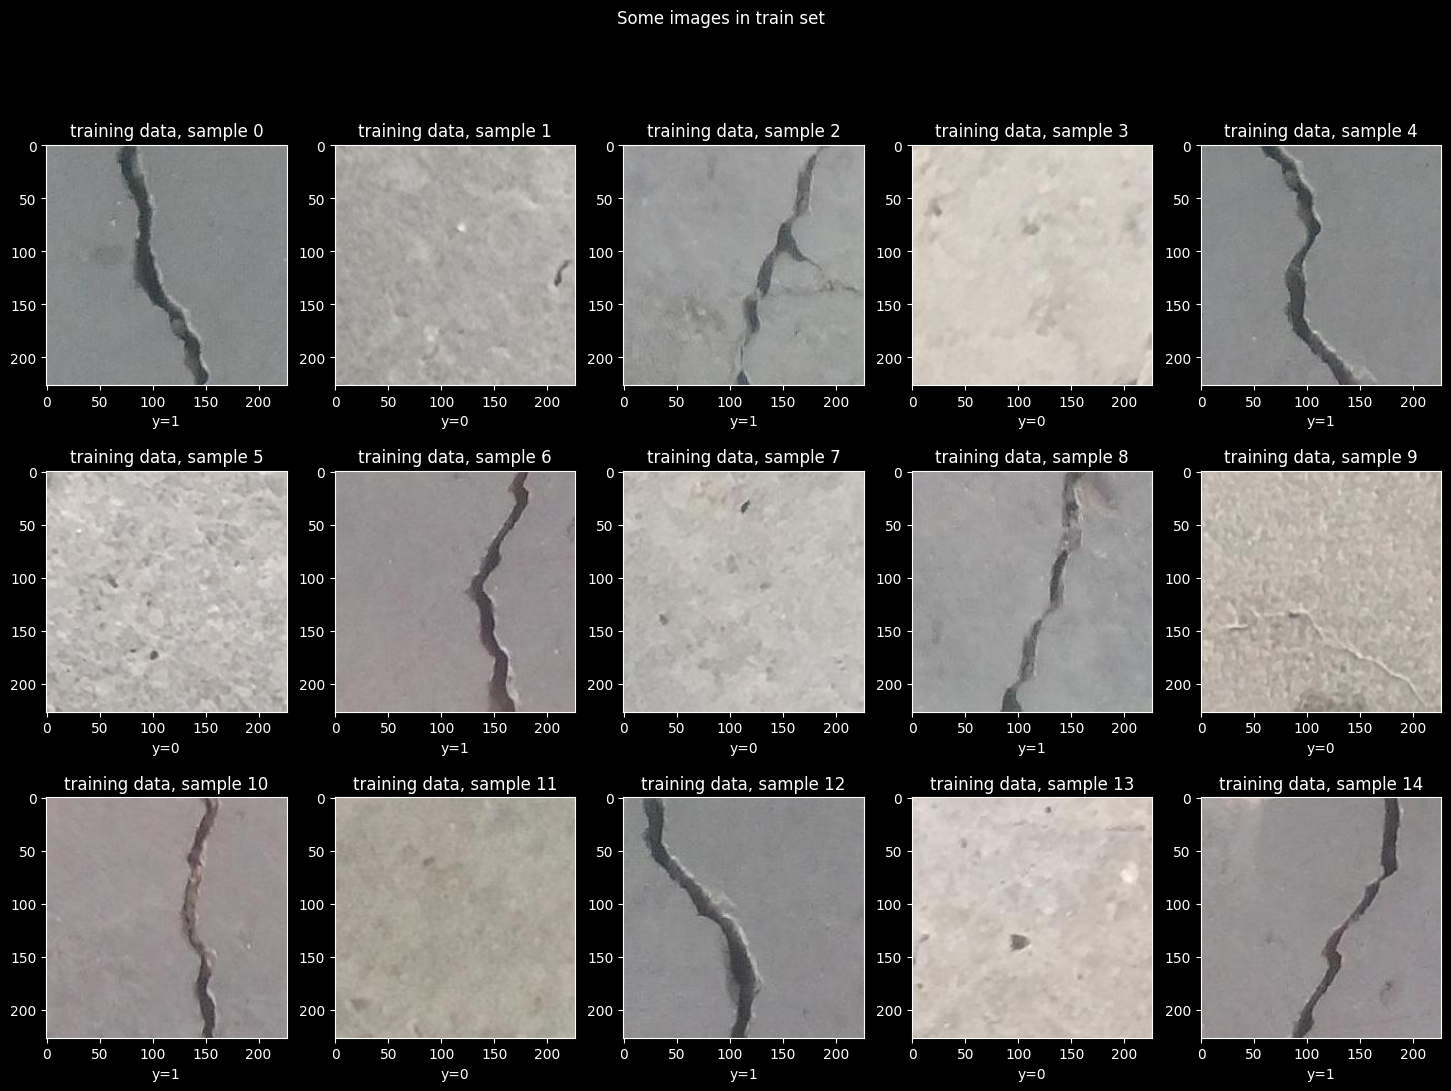

In [8]:
dataset = Dataset(train=True)

plt.figure(figsize=(18,12))
plt.suptitle('Some images in train set')
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(dataset[i][0])
    plt.xlabel("y="+str(dataset[i][1].item()))
    plt.title("training data, sample {}".format(i)) 

##### Train and validation datasets

In [9]:
transform = torchvision.transforms.ToTensor()

train_dataset = Dataset(train=True, transform=transform)
validation_dataset = Dataset(train=False, transform=transform)
print("done")

done


### ResNet18, pretrained model

In [10]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad =False

model.fc = torch.nn.Linear(512,2)

In [11]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training the last layer

In [12]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=True)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

In [13]:
validation_dataset[0][0].shape

torch.Size([3, 227, 227])

In [14]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)

#Loss=0
for epoch in range(n_epochs):
    for x, y in train_loader:
        model.train() 
        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        z = model(x)
        # calculate loss
        loss = criterion(z, y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
        loss_list.append(loss.data)
    correct=0
    for x_test, y_test in validation_loader:
        # set model to eval 
        model.eval()
        #make a prediction 
        z = model(x_test)
        #find max 
        _, yhat = torch.max(z.data,1)
        #Calculate misclassified  samples in mini-batch 
        correct +=(yhat==y_test).sum().item()  
        accuracy_list.append(correct/N_test)
    accuracy=correct/N_test


## Results

In [15]:
accuracy

0.9858

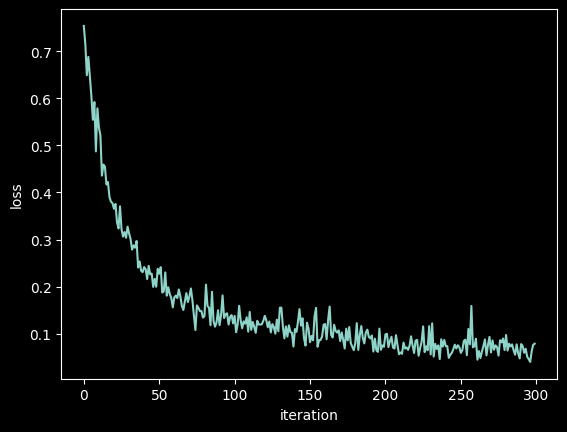

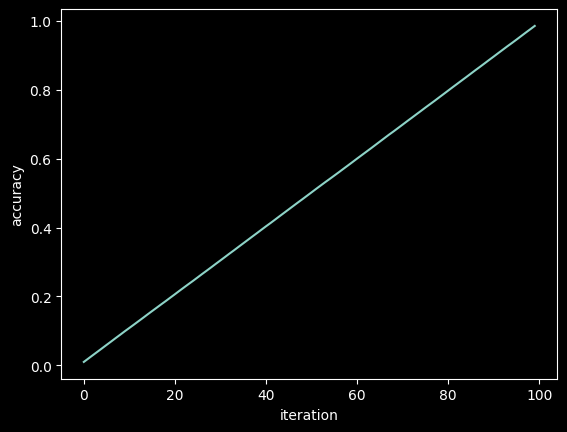

In [16]:
plt.plot(loss_list)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

plt.plot(accuracy_list)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

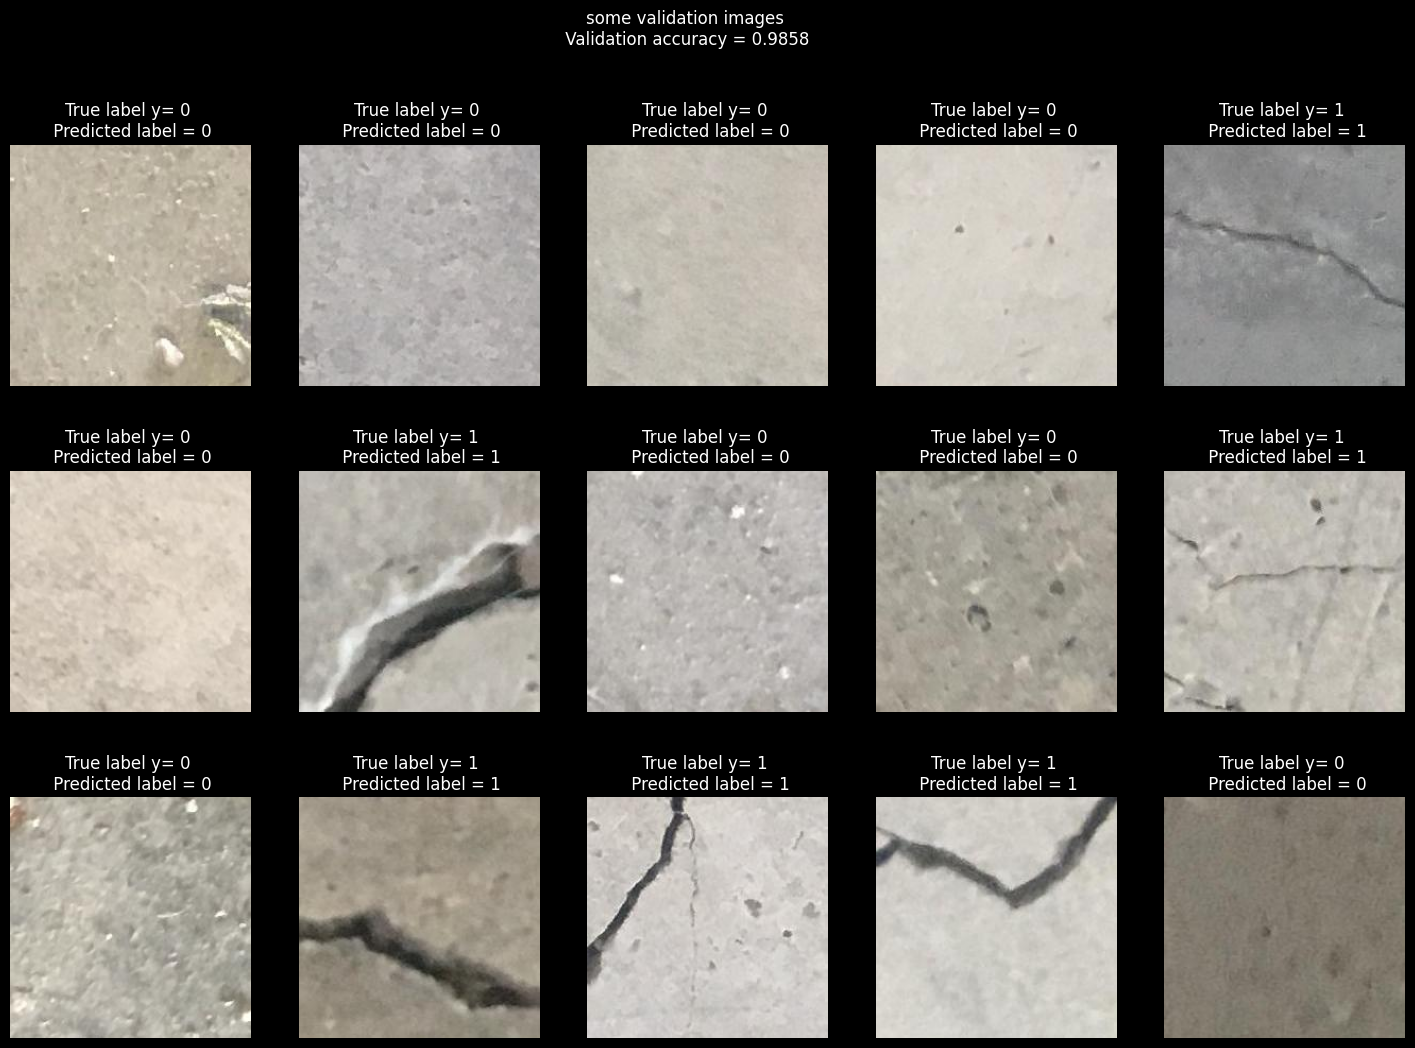

In [17]:
#count = 0
model.eval()
x,y =next(iter(validation_loader))

plt.figure(figsize=(18,12))
plt.suptitle(f'some validation images\n Validation accuracy = {accuracy}')
z = model(x)
_, yhat = torch.max(z,1)
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(x[i].numpy().transpose((1,2,0)))
    #plt.xlabel("True label y="+str(y[i].item()))
    plt.title(f'True label y= {y[i].item()} \n Predicted label = {yhat[i].item()}') 
    plt.axis('off')